In [233]:
import pandas as pd
import torch 
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision 
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import requests
import json
import ast
import os

import difflib
import random
from tqdm import tqdm

In [236]:
# torch.cuda.current_device()

In [275]:
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)

In [240]:
# if torch.cuda.current_device():
#     device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     torch.device('mps')
# else:
#     torch.device('cpu')

In [241]:
# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [276]:
torch.device('cpu')

device(type='cpu')

In [279]:
device='cpu'

### Comparing Classes from Caltech101 dataset and ImageNet

In [280]:
# --- get dictionary for image net
imagenet_dct_url = "https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a/raw"
resp = requests.get(imagenet_dct_url, verify=False)
dct_imagenet = ast.literal_eval(resp.text)

/Users/emulie/pvenv/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gist.github.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/emulie/pvenv/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gist.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [281]:
# --- get classes names for caltech101
with open('../caltech-dct.txt', 'r') as f:
    classes_caltech101 = f.readlines()
classes_caltech101 = [name.strip().lower() for name in classes_caltech101]

In [282]:
classes_caltech101[:5]

['faces', 'faces_easy', 'leopards', 'motorbikes', 'accordion']

In [283]:
classes_imagenet = [name.lower() for name in dct_imagenet.values()]
classes_imagenet[:5]

['tench, tinca tinca',
 'goldfish, carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, carcharodon carcharias',
 'tiger shark, galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

In [284]:
# --- compute overlapping classes
classes_imagenet_split = [classe.split(', ') for classe in classes_imagenet]
classes_imagenet_split = [[word.replace(' ', '_') for word in classe] for classe in classes_imagenet_split]
classes_imagenet_split[:5]

[['tench', 'tinca_tinca'],
 ['goldfish', 'carassius_auratus'],
 ['great_white_shark',
  'white_shark',
  'man-eater',
  'man-eating_shark',
  'carcharodon_carcharias'],
 ['tiger_shark', 'galeocerdo_cuvieri'],
 ['hammerhead', 'hammerhead_shark']]

In [285]:
classes_imagenet_flat_lst = [word for classe in classes_imagenet for word in classe]

In [286]:
classes_imagenet_flat_lst2 = [word for classe in classes_imagenet for word in classe.replace(',', '').split(' ')]
classes_imagenet_flat_lst2[:5]

['tench', 'tinca', 'tinca', 'goldfish', 'carassius']

In [75]:
missing_classes = []
matching_classes = []
for caltech101_class in classes_caltech101:
    closest_classes = difflib.get_close_matches(caltech101_class, classes_imagenet_flat_lst2, n=1, cutoff=0.8)
    
    if len(closest_classes) == 0:
        missing_classes.append(caltech101_class)
    else:
        matching_classes.append((caltech101_class, closest_classes))
        

In [77]:
matching_classes

[('faces', ['face']),
 ('leopards', ['leopard']),
 ('accordion', ['accordion']),
 ('airplanes', ['warplane']),
 ('ant', ['ant']),
 ('barrel', ['barrel']),
 ('bass', ['brass']),
 ('beaver', ['beaver']),
 ('binocular', ['binoculars']),
 ('bonsai', ['bonasa']),
 ('brain', ['brain']),
 ('butterfly', ['butterfly']),
 ('camera', ['camera']),
 ('cannon', ['cannon']),
 ('cellphone', ['cellphone']),
 ('chair', ['chair']),
 ('crab', ['crab']),
 ('crayfish', ['crayfish']),
 ('crocodile', ['crocodile']),
 ('cup', ['cup']),
 ('dalmatian', ['dalmatian']),
 ('dragonfly', ['dragonfly']),
 ('elephant', ['elephant']),
 ('ewer', ['ewer']),
 ('ferry', ['kerry']),
 ('flamingo', ['flamingo']),
 ('hedgehog', ['hedgehog']),
 ('kangaroo', ['kangaroo']),
 ('lamp', ['lamp']),
 ('laptop', ['laptop']),
 ('llama', ['llama']),
 ('lobster', ['lobster']),
 ('nautilus', ['nautilus']),
 ('panda', ['panda']),
 ('pizza', ['pizza']),
 ('platypus', ['platypus']),
 ('revolver', ['revolver']),
 ('saxophone', ['saxophone']),
 

In [78]:
missing_classes

['faces_easy',
 'motorbikes',
 'anchor',
 'brontosaurus',
 'buddha',
 'car_side',
 'ceiling_fan',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crocodile_head',
 'dollar_bill',
 'dolphin',
 'electric_guitar',
 'emu',
 'euphonium',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'ketch',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'octopus',
 'okapi',
 'pagoda',
 'pigeon',
 'pyramid',
 'rhino',
 'rooster',
 'scissors',
 'snoopy',
 'soccer_ball',
 'stegosaurus',
 'stop_sign',
 'sunflower',
 'water_lilly',
 'wheelchair',
 'wild_cat',
 'windsor_chair',
 'yin_yang']

In [88]:
print(f"Missing classes: {len(missing_classes) / len(classes_caltech101) * 100:2f}% ({len(missing_classes)}/{len(classes_caltech101)})")

Missing classes: 51.485149% (52/101)


### Load CalTech101 Dataset

In [107]:
# TODO: download data from kaggle https://www.kaggle.com/datasets/imbikramsaha/caltech-101
import kagglehub

path = kagglehub.dataset_download("imbikramsaha/caltech-101")

100%|████████████████████████████████████████████████████████████████████| 131M/131M [00:04<00:00, 27.5MB/s]

Extracting files...


In [108]:
path

'/Users/emulie/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1'

In [219]:
torch.manual_seed(42)

In [287]:
class Caltech101Dataset(Dataset):
    
    def __init__(self, dataset_dir: int, split: str, transform=None, train_split: float = 0.8):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.split = split
        self.train_split = train_split
        
        self.classes = os.listdir(dataset_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()
    
    def _load_images(self):
        images = []
        for cls in self.classes:
            class_dir = os.path.join(self.dataset_dir, cls)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
                
        random.shuffle(images)
        
        e_train = int(len(images) * self.train_split)
        if self.split == "train":
            images = images[:e_train]
        elif self.split == "test":
            images = images[e_train:]
        else:
            raise ValueError("Invalid split value. Specify 'train' or 'test' ")
        
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        else:
            image = image.resize((64, 64))
            image = np.asarray(image) / 255
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float32)

        return image, label

In [288]:
dataset_dir = path + '/caltech-101/'
train_dataset = Caltech101Dataset(dataset_dir, split='train')
test_dataset = Caltech101Dataset(dataset_dir, split='test')

train_dataloader = DataLoader(train_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [293]:
# --- TODO: visualize image 
batch, labels = next(iter(train_dataloader))

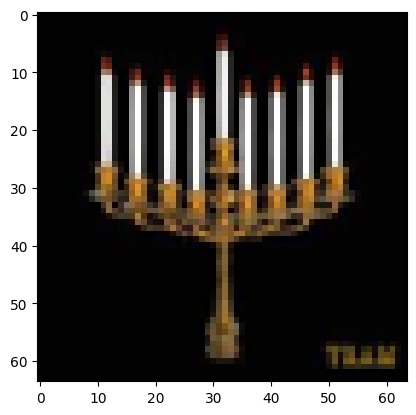

In [294]:
plt.imshow(batch[7].permute(1, 2, 0))

In [295]:
batch.shape

torch.Size([8, 3, 64, 64])

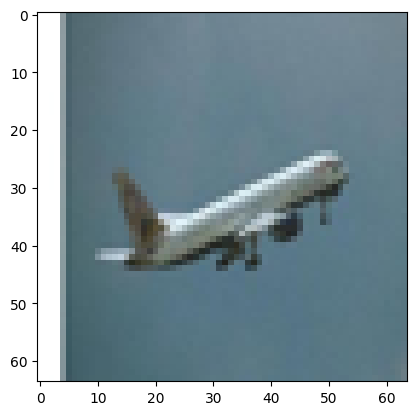

In [296]:
plt.imshow(batch[2].permute(1, 2, 0))

### 

### VGG19 performance on CalTech101 dataset

In [289]:
vgg19 = torchvision.models.vgg19(weights='DEFAULT')
vgg19.eval()
vgg19.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [297]:
def get_top_image_classification(model, img_tensors, device='cpu', top_k: int = 5):
    # compute prediction
    output = model(img_tensors.to(device))
    probs = F.softmax(output)
    topk_prob, topk_catid = torch.topk(probs, top_k)
    
    # convert prediction classes to class name
    top_results = []
    batch_size = topk_prob.shape[0]
    for batch_idx in range(batch_size):
        batch_res = []
        for prob, catid in zip(topk_prob[batch_idx], topk_catid[batch_idx]):
            idx = catid.item()
            batch_res.append((idx, dct_imagenet[idx], prob.item()))
        top_results.append(batch_res)
    
    return top_results

In [298]:
get_top_image_classification(vgg19, batch[7].unsqueeze(0), device, top_k=5)

/var/folders/ft/zzyxfrm96v3dk85k23qrmdww0000gp/T/ipykernel_94094/986337166.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(output)


[[(619, 'lampshade, lamp shade', 0.8250563144683838),
  (846, 'table lamp', 0.09704776853322983),
  (677, 'nail', 0.0326584130525589),
  (783, 'screw', 0.01641058176755905),
  (494, 'chime, bell, gong', 0.010062554851174355)]]

In [299]:
print(train_dataset.idx_to_class[labels[7].item()])

menorah


In [300]:
get_top_image_classification(vgg19, batch[2].unsqueeze(0), top_k=5)

/var/folders/ft/zzyxfrm96v3dk85k23qrmdww0000gp/T/ipykernel_94094/986337166.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(output)


[[(894, 'wardrobe, closet, press', 0.49196451902389526),
  (760, 'refrigerator, icebox', 0.2503051161766052),
  (648, 'medicine chest, medicine cabinet', 0.14042799174785614),
  (553, 'file, file cabinet, filing cabinet', 0.08669217675924301),
  (493, 'chiffonier, commode', 0.013107785023748875)]]

In [301]:
print(train_dataset.idx_to_class[labels[2].item()])

airplanes


### Fine-Tuning VGG19 model

In [326]:
class VGG19_Caltech(nn.Module):
    
    def __init__(self, num_classes=102):
        super(VGG19_Caltech, self).__init__()
        self.num_classes = num_classes

        self.features = vgg19.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [327]:
model = VGG19_Caltech(num_classes=len(train_dataset.classes))
model.to(device)

VGG19_Caltech(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [ ]:
# --- TODO: training model with caltech data

In [336]:
def train_model(model, dataloader, loss_fn, optimizer, epoch, nb_epochs, device):
    model.train()
    
    with tqdm(total=len(dataloader), dynamic_ncols=True) as tq:
        tq.set_description(f"Training :: Epoch {epoch}/{nb_epochs})")
        
        running_losses = []
        for i, batch in enumerate(dataloader):
            tq.update(1)
            
            # get batch x,y
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            # get predictions
            preds = model(inputs)
            loss = loss_fn(preds, labels)
            running_losses.append(loss)
            
            # update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        avg_loss = sum(running_losses) / len(running_losses)
        tq.set_postfix_str(s=f"Loss : {avg_loss:.6f}")
        
        return avg_loss

In [338]:
@torch.no_grad()
def eval_model(model, dataloader, loss_fn, device):

    model.eval()

    with tqdm(total=len(dataloader), dynamic_ncols=True) as tq:
        tq.set_description(':: Evaluation :')

        running_losses = []
        for i, batch in enumerate(dataloader):
            tq.update(1)

            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs)
            loss = loss_fn(predictions, labels)
            running_losses.append(loss)

        avg_loss = sum(running_losses) / len(running_losses)
        tq.set_postfix_str(s=f'Loss: {avg_loss:.6f}')

    return avg_loss


In [339]:
# --- TODO: compare vgg19 performance vs vgg19 performance

In [340]:
# loss_fn = nn.KLDivLoss().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters())
nb_epochs = 1

In [341]:
training_losses, validation_losses = [], []
for epoch in range(1, nb_epochs+1):
    training_losses.append(train_model(model, train_dataloader, loss_fn, optimizer, epoch, nb_epochs, device))
    validation_losses.append(eval_model(model, test_dataloader, loss_fn, device))

:: Evaluation :: 100%|███████████████████████████| 229/229 [01:03<00:00,  3.61it/s, Loss: 4.191912]


### Making predictions with VGG19 Fine-Tune Model